# Part 3: Higgs bosons

In [1]:
import awkward as ak
from hist import Hist
import vector
vector.register_awkward()

In [2]:
# load all events
events = ak.from_parquet("data/SMHiggsToZZTo4L.parquet")
original_event_count = len(events)
events.show(all=True)

type: 299973 * {
    run: int32,
    luminosityBlock: int64,
    event: uint64,
    PV: Vector3D[
        x: float32,
        y: float32,
        z: float32
    ],
    electron: var * Momentum4D[
        pt: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        charge: int32,
        pfRelIso03_all: float32,
        dxy: float32,
        dxyErr: float32,
        dz: float32,
        dzErr: float32
    ],
    muon: var * Momentum4D[
        pt: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        charge: int32,
        pfRelIso03_all: float32,
        pfRelIso04_all: float32,
        dxy: float32,
        dxyErr: float32,
        dz: float32,
        dzErr: float32
    ],
    MET: Momentum2D[
        pt: float32,
        phi: float32
    ]
}
nbytes: 53.2 MB
backend: cpu
[{run: 1, luminosityBlock: 156, event: 46501, PV: {...}, electron: [], ...},
 {run: 1, luminosityBlock: 156, event: 46502, PV: {...}, electron: [...], ...},
 {

### Higgs boson decays via Z bosons

This dataset comprises Higgs boson decays via Z bosons to leptons, the decay chain is:

**H** $\rightarrow$ **ZZ** $\rightarrow$ **4l**, 

where **4l** can be any combination of **$\mu^+\mu^-$** and **$e^+e^-$**, i.e. **$\mu^+\mu^-\mu^+\mu^-$**, **$e^+e^-e^+e^-$**, **$e^+e^-\mu^+\mu^-$**, or **$\mu^+\mu^- e^+e^-$**.

## Task: Reconstruct potential Higgs boson candidates 

The reconstruction happens in 'reversed' order as the dataset contains only muons ($\mu$) and electrons ($e$).

The basic algorithm is as follows:
1. Select only leptons using quality cuts: each muon or electron should have $p_T>20$GeV and $abs(eta) < 2.4$ (detector region). <details><summary>Tip</summary>use `events["muons"] = events.muons[...]` to save the masked muon collection.</details>
2. Select only events that have 4 leptons in it as we expect: **$\mu^+\mu^-\mu^+\mu^-$**, **$e^+e^-e^+e^-$**, **$e^+e^-\mu^+\mu^-$**, or **$\mu^+\mu^- e^+e^-$**. How many events have we selected? What's the selection efficiency? <details><summary>Tip</summary>use `ak.num` to determine the number of electrons and muons in events.</details>
3. Define four leptons `l1, l2, l3, l4` using `ak.combinations` and `ak.unzip` and create a Higgs boson by adding those four-momenta up. <details><summary>Tip</summary>use `ak.concatenate` to combine electrons and muons to leptons.</details>
4. Calculate the invariant mass of the 4 leptons and make a plot


Number of events with 4 good leptons: 4422 (originally 299973)
Selection efficiency: 1.47%


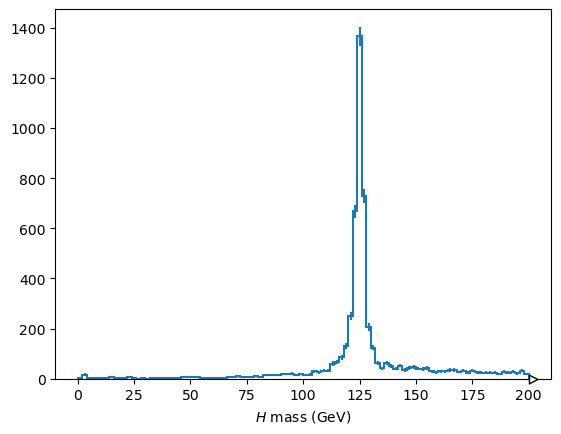

In [3]:
# Step 1: Select leptons
events["muons"] = events.muon[(events.muon.pt > 20) & (abs(events.muon.eta) < 2.4)]
events["electrons"] = events.electron[(events.electron.pt > 20) & (abs(events.electron.eta) < 2.4)]

# Step 2: Select events with 4 leptons
# Select events with atleast 4 leptons (muons and/or electrons), after our lepton selection
four_lepton_mask = (
    # mmmm
    (ak.num(events.muons) >= 4) |
    # eeee
    (ak.num(events.electrons) >= 4) |
    # mmee, eemm
    ((ak.num(events.muons) >= 2) & (ak.num(events.electrons) >= 2))
)
events = events[four_lepton_mask]

print(f"Number of events with 4 good leptons: {len(events)} (originally {original_event_count})")
print(f"Selection efficiency: {(len(events) / original_event_count):.2%}")

# Step 3: Define four leptons and reconstruct Higgs candidates
leptons = ak.concatenate([events.muons, events.electrons], axis=1)
events["leptons"] = leptons
l1, l2, l3, l4 = ak.unzip(ak.combinations(leptons, 4))
higgs_candidates = l1 + l2 + l3 + l4

# mass 
H_simple_mass = ak.flatten(higgs_candidates.mass)

# Step 4: Plot Higgs mass
Hist.new.Regular(100, 0, 200, name="$H$ mass (GeV)").Double().fill(H_simple_mass).plot();


## Bonus Tasks

1. Improve the previous reconstruction of higgs bosons, by that fact that we know that the Higgs and Z bosons are neutrally charged, and charge is conserved. Before reconstructing the higgs boson make sure that the 'charge sum' of all leptons remains zero.

2. We know that one of the two Z bosons has to be off-shell and one has to be on-shell due to the Higgs mass. Find the on-shell Z boson and all potential off-shell Z bosons in all events after the lepton quality cuts (original task - step 1). Make a plot of their mass distributions each (one plot for on-shell, one for off-shell).

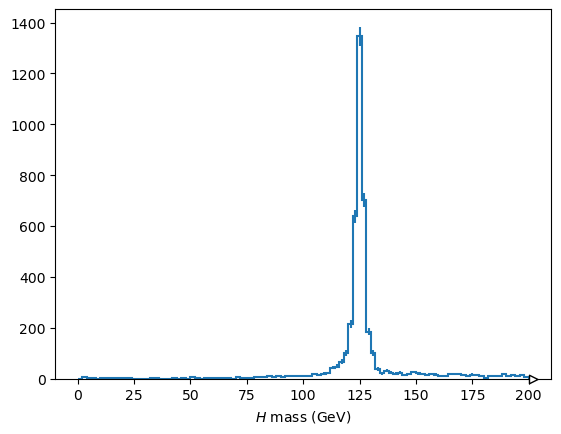

In [4]:
# Bonus task 1:
higgs_candidates = l1 + l2 + l3 + l4
higgs_candidates = higgs_candidates[(l1.charge + l2.charge + l3.charge + l4.charge) == 0]

Hist.new.Regular(100, 0, 200, name="$H$ mass (GeV)").Double().fill(
    ak.flatten(higgs_candidates.mass)
).plot();

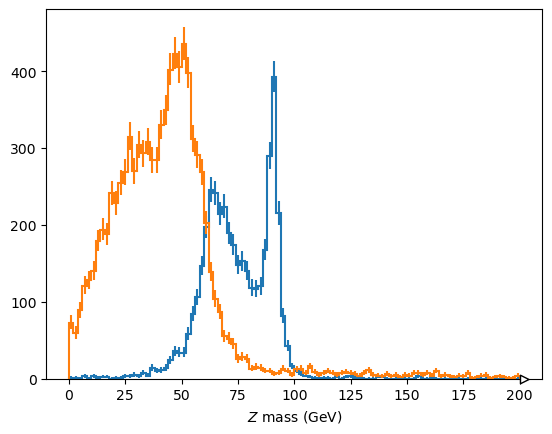

In [5]:
# Bonus task 2: Reconstruct on-shell and off-shell Z bosons
events = ak.from_parquet("data/SMHiggsToZZTo4L.parquet")

events["muons"] = events.muon[(events.muon.pt > 20) & (abs(events.muon.eta) < 2.4)]
events["electrons"] = events.electron[(events.electron.pt > 20) & (abs(events.electron.eta) < 2.4)]

four_lepton_mask = (
    # mmmm
    (ak.num(events.muons) >= 4) |
    # eeee
    (ak.num(events.electrons) >= 4) |
    # mmee, eemm
    ((ak.num(events.muons) >= 2) & (ak.num(events.electrons) >= 2))
)
events = events[four_lepton_mask]

e1, e2 = ak.unzip(ak.combinations(events.electrons, 2))
m1, m2 = ak.unzip(ak.combinations(events.muons, 2))

Zee = e1 + e2
Zmm = m1 + m2

# only keep opposite-sign pairs (Z boson is neutral)
Zee = Zee[(e1.charge + e2.charge) == 0]
Zmm = Zmm[(m1.charge + m2.charge) == 0]

# combine all Z candidates
Z = ak.concatenate([Zee, Zmm], axis=-1)

# require at least 2 pairs (otherwise we can't have on-shell and off-shell)
Z = Z[ak.num(Z) >= 2]

# sort by how close they are to the Z mass
Zmass = 91.2 # GeV
Z = Z[ak.argsort(abs(Z.mass - Zmass), ascending=True)]

# on-shell: closest to Z mass
Z_on_shell_mass = Z[:, 0].mass

# off-shell: all others
Z_off_shell_mass = ak.flatten(Z[:, 1:]).mass

Hist.new.Regular(100, 0, 200, name="$Z$ mass (GeV)").Double().fill(Z_on_shell_mass).plot();
Hist.new.Regular(100, 0, 200, name="$Z$ mass (GeV)").Double().fill(Z_off_shell_mass).plot();


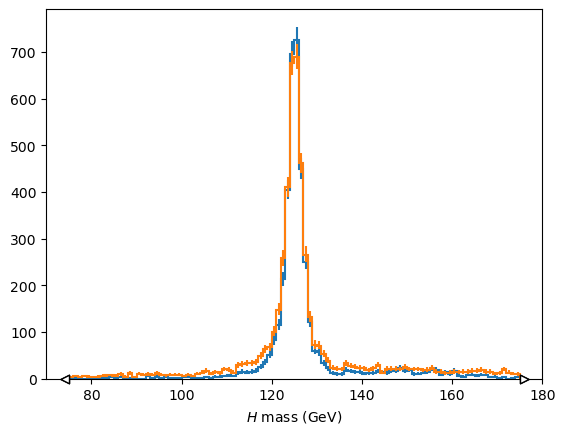

In [6]:
# Bonus task 2: Reconstruct the Higgs using the best pair of on-shell and off-shell Z bosons

# create all possible Z pairs between the on-shell Z and all off-shell Z's per event
Zpairs = ak.cartesian([Z[:, 0:1], Z[:, 1:]])
Z1, Z2 = ak.unzip(Zpairs)

Hmass = 125.0 # GeV

# sort by how close they are to the higgs mass
Zpairs = Zpairs[ak.argsort(abs((Z1 + Z2).mass - Hmass), ascending=True)]

# get Z's (closest to Higgs mass)
Zon, Zoff = ak.unzip(Zpairs[:, 0])

# mass
H_mass = ak.flatten((Zon + Zoff).mass, axis=-1)

# plot
Hist.new.Regular(100, 75, 175, name="$H$ mass (GeV)").Double().fill(H_mass).plot();
Hist.new.Regular(100, 75, 175, name="$H$ mass (GeV)").Double().fill(H_simple_mass).plot();